LSTM
=============

------------

The goal here is to train a LSTM character model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [36]:
import os
from IPython.display import Image
import numpy as np
import random
import string
import tensorflow as tf
import zipfile
from urllib.request import urlretrieve

In [2]:
# text is a long string of charachters
def read_data(filename):
    with zipfile.ZipFile(filename) as f:
        name = f.namelist()[0]
        #data = tf.compat.as_str(f.read(name))
        data = f.read(name).decode('utf-8')
    return data

text = read_data('text8.zip')
print('Data size %d' % len(text))

Data size 100000000


Create a small validation set.

In [3]:
valid_size = 1000
valid_text = text[:valid_size]
train_text = text[valid_size:]
train_size = len(train_text)
print(train_size, train_text[:64])
print(valid_size, valid_text[:64])

99999000 ons anarchists advocate social relations based upon voluntary as
1000  anarchism originated as a term of abuse first used against earl


In [4]:
# Utility functions to map characters to vocabulary IDs and back.
vocabulary_size = len(string.ascii_lowercase) + 1 # [a-z] + ' '
first_letter    = ord(string.ascii_lowercase[0])

def char2id(char):
    if char in string.ascii_lowercase:
        return ord(char) - first_letter + 1
    elif char == ' ':
        return 0
    else:
        print('Unexpected character: %s' % char)
    return 0
  
def id2char(dictid):
    if dictid > 0:
        return chr(dictid + first_letter - 1)
    else:
        return ' '

print(char2id('a'), char2id('z'), char2id(' ')) #, char2id('ï'))
print(id2char(1), id2char(26), id2char(0))
print(char2id('ï'))

1 26 0
a z  
Unexpected character: ï
0


Function to generate a training batch for the LSTM model.

In [7]:
batch_size     = 64
num_unrollings = 10

class BatchGenerator(object):
    def __init__(self, text, batch_size, num_unrollings):
        self._text = text
        self._text_size = len(text)
        self._batch_size = batch_size
        self._num_unrollings = num_unrollings
        segment = self._text_size // batch_size
        self._cursor = [ offset * segment for offset in range(batch_size)]
        self._last_batch = self._next_batch()

    def _next_batch(self):
        """Generate a single batch from the current cursor position in the data."""
        batch = np.zeros(shape=(self._batch_size, vocabulary_size), dtype=np.float)
        for b in range(self._batch_size):
            batch[b, char2id(self._text[self._cursor[b]])] = 1.0
            self._cursor[b] = (self._cursor[b] + 1) % self._text_size
        return batch
  
    def next(self):
        """Generate the next array of batches from the data. The array consists of
        the last batch of the previous array, followed by num_unrollings new ones.
        """
        batches = [self._last_batch]
        for step in range(self._num_unrollings):
            batches.append(self._next_batch())
        self._last_batch = batches[-1]
        return batches

In [24]:
#train_batches = BatchGenerator(train_text, batch_size, num_unrollings)
batch = train_batches.next()

In [18]:
def characters(probabilities):
    """Turn a 1-hot encoding or a probability distribution over the possible
    characters back into its (most likely) character representation."""
    return [id2char(c) for c in np.argmax(probabilities, 1)]

def batches2string(batches):
    """Convert a sequence of batches back into their (most likely) string
    representation."""
    s = [''] * batches[0].shape[0]
    for b in batches:
        s = [''.join(x) for x in zip(s, characters(b))]
    return s

train_batches = BatchGenerator(train_text, batch_size, num_unrollings)
valid_batches = BatchGenerator(valid_text, 1, 1)

In [34]:
print(batches2string(train_batches.next()))
print(batches2string(train_batches.next()))
print(batches2string(valid_batches.next()))
print(batches2string(valid_batches.next()))

['y defined b', ' was open f', 'united stat', 'amed after ', 'e reference', 'd in one ni', 'he turbulen', 'to nine zer', 'age as the ', 'ro s belize', 'filters cra', 'aisle ratio', ' with the t', 'many aspect', 'f the legio', 'ut the shuf', 'eight zero ', 'sm for the ', 'e two eprin', 'rse has alw', 'ded the con', ' crystal st', 't is n bits', ' three to o', 'itory or vi', 'ed to accom', ' variety of', ' an indian ', 'le parties ', 'are to tran', 'ilar inner ', 'e down the ', ' to print d', 'ich plays t', ' remaining ', ' s aircraft', 'y ways inte', 'in the eu p', ' decay fiss', 'er to entir', 'either to r', 'he river in', 'frac two x ', 'pe a and d ', 'ly was unif', 'rger amongs', 'r the unite', 'pagation of', 'reported be', 's been seen', 'f the econo', 'ng on also ', ' the compan', 'hikuni the ', 'eaving the ', 'ity francis', 'hooting the', 'ero zero a ', 'ng and the ', 'ociation fo', 'ommonly ref', 'e four one ', 'er faiths o', 'pls works m']
['by what it ', 'for per n s', 'tes nat

In [35]:
def logprob(predictions, labels):
    """Log-probability of the true labels in a predicted batch."""
    predictions[predictions < 1e-10] = 1e-10
    return np.sum(np.multiply(labels, -np.log(predictions))) / labels.shape[0]

def sample_distribution(distribution):
    """Sample one element from a distribution assumed to be an array of normalized
    probabilities.
    """
    r = random.uniform(0, 1)
    s = 0
    for i in range(len(distribution)):
        s += distribution[i]
    if s >= r:
        return i
    return len(distribution) - 1

def sample(prediction):
    """Turn a (column) prediction into 1-hot encoded samples."""
    p = np.zeros(shape=[1, vocabulary_size], dtype=np.float)
    p[0, sample_distribution(prediction[0])] = 1.0
    return p

def random_distribution():
    """Generate a random column of probabilities."""
    b = np.random.uniform(0.0, 1.0, size=[1, vocabulary_size])
    return b/np.sum(b, 1)[:,None]

Simple LSTM Model.

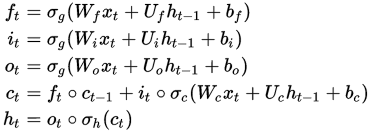

In [38]:
Image(filename='LSTM.png')

In [39]:
num_nodes = 64

graph = tf.Graph()
with graph.as_default():
  
  # Parameters:
  # Input gate: input, previous output, and bias.
  ix = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  im = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  ib = tf.Variable(tf.zeros([1, num_nodes]))
  # Forget gate: input, previous output, and bias.
  fx = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  fm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  fb = tf.Variable(tf.zeros([1, num_nodes]))
  # Memory cell: input, state and bias.                             
  cx = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  cm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  cb = tf.Variable(tf.zeros([1, num_nodes]))
  # Output gate: input, previous output, and bias.
  ox = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  om = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  ob = tf.Variable(tf.zeros([1, num_nodes]))
  # Variables saving state across unrollings.
  saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  saved_state  = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  # Classifier weights and biases.
  w = tf.Variable(tf.truncated_normal([num_nodes, vocabulary_size], -0.1, 0.1))
  b = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Definition of the cell computation.
  def lstm_cell(i, o, state):
    """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
    Note that in this formulation, we omit the various connections between the
    previous state and the gates."""
    input_gate  = tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
    forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
    output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
    update      = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
    state       = forget_gate * state + input_gate * tf.tanh(update)
   
    return output_gate * tf.tanh(state), state

  # Input data.
  train_data = list()
  for _ in range(num_unrollings + 1):
    train_data.append(
      tf.placeholder(tf.float32, shape=[batch_size,vocabulary_size]))
  train_inputs = train_data[:num_unrollings]
  train_labels = train_data[1:]  # labels are inputs shifted by one time step.

  # Unrolled LSTM loop.
  outputs = list()
  output  = saved_output 
  state   = saved_state
  for i in train_inputs:
    output, state = lstm_cell(i, output, state)
    outputs.append(output)

  # State saving across unrollings.
  with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
    # Classifier.
    logits = tf.nn.xw_plus_b(tf.concat(outputs, 0), w, b)
    loss   = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
        labels=tf.concat(train_labels, 0), logits=logits))

  # Optimizer.
  global_step   = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(
        10.0, global_step, 5000, 0.1, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  gradients, v = zip(*optimizer.compute_gradients(loss))
  gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
  optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)

  # Predictions.
  train_prediction = tf.nn.softmax(logits)
  
  # Sampling and validation eval: batch 1, no unrolling.
  sample_input        = tf.placeholder(tf.float32, shape=[1, vocabulary_size])
  saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
  saved_sample_state  = tf.Variable(tf.zeros([1, num_nodes]))
  reset_sample_state  = tf.group(
    saved_sample_output.assign(tf.zeros([1, num_nodes])),
    saved_sample_state.assign(tf.zeros([1, num_nodes])))
  sample_output, sample_state = lstm_cell(
    sample_input, saved_sample_output, saved_sample_state)
  with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                saved_sample_state.assign(sample_state)]):
    sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, w, b))

In [40]:
num_steps = 7001
summary_frequency = 100

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  mean_loss = 0
  for step in range(num_steps):
    batches = train_batches.next()
    feed_dict = dict()
    for i in range(num_unrollings + 1):
      feed_dict[train_data[i]] = batches[i]
    _, l, predictions, lr = session.run(
      [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
    mean_loss += l
    if step % summary_frequency == 0:
      if step > 0:
        mean_loss = mean_loss / summary_frequency
      # The mean loss is an estimate of the loss over the last few batches.
      print(
        'Average loss at step %d: %f learning rate: %f' % (step, mean_loss, lr))
      mean_loss = 0
      labels = np.concatenate(list(batches)[1:])
      print('Minibatch perplexity: %.2f' % float(
        np.exp(logprob(predictions, labels))))
      if step % (summary_frequency * 10) == 0:
        # Generate some samples.
        print('=' * 80)
        for _ in range(5):
          feed = sample(random_distribution())
          sentence = characters(feed)[0]
          reset_sample_state.run()
          for _ in range(79):
            prediction = sample_prediction.eval({sample_input: feed})
            feed = sample(prediction)
            sentence += characters(feed)[0]
          print(sentence)
        print('=' * 80)
      # Measure validation set perplexity.
      reset_sample_state.run()
      valid_logprob = 0
      for _ in range(valid_size):
        b = valid_batches.next()
        predictions = sample_prediction.eval({sample_input: b[0]})
        valid_logprob = valid_logprob + logprob(predictions, b[1])
      print('Validation set perplexity: %.2f' % float(np.exp(
        valid_logprob / valid_size)))

Initialized
Average loss at step 0: 3.293578 learning rate: 10.000000
Minibatch perplexity: 26.94
zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz
zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz
zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz
zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz
zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz
Validation set perplexity: 19.96
Average loss at step 100: 2.586821 learning rate: 10.000000
Minibatch perplexity: 11.03
Validation set perplexity: 10.68
Average loss at step 200: 2.238401 learning rate: 10.000000
Minibatch perplexity: 8.48
Validation set perplexity: 8.93
Average loss at step 300: 2.099173 learning rate: 10.000000
Minibatch perplexity: 7.63
Validation set perplexity: 8.01
Average loss at step 400: 1.999820 learning rate: 10.000000
Minibatch perplexity: 7.12
Validation set per

Validation set perplexity: 4.57
Average loss at step 4500: 1.615416 learning rate: 10.000000
Minibatch perplexity: 5.08
Validation set perplexity: 4.68
Average loss at step 4600: 1.621165 learning rate: 10.000000
Minibatch perplexity: 5.33
Validation set perplexity: 4.60
Average loss at step 4700: 1.620822 learning rate: 10.000000
Minibatch perplexity: 5.86
Validation set perplexity: 4.55
Average loss at step 4800: 1.636343 learning rate: 10.000000
Minibatch perplexity: 5.39
Validation set perplexity: 4.57
Average loss at step 4900: 1.628041 learning rate: 10.000000
Minibatch perplexity: 5.62
Validation set perplexity: 4.63
Average loss at step 5000: 1.603053 learning rate: 1.000000
Minibatch perplexity: 4.48
zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz
zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz
zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz
zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz

In [43]:
feed = sample(random_distribution())
sentence = characters(feed)[0]
sentence

'z'